# Data Exploration

Preprocessing steps which we could take:

- Remove/check 'R_A' , 'R_V' and 'R' from `ACTIVITY_TYPE`. Very few occurences, not sure what they represent (maybe ask first).
- Remove 'NB', 'VB' and 'VST' from `TRAINSERIE_DIRECTION`. Same story as above.
- Remove 'MS' from `ROLLINGSTOCK_TYPE`,  NS people said this train was not relevant.
- Change `SPLIT` and `COMBINE` to a binary value.
- Give `ROLLINGSTOCK_TYPE` and `STATION` categorical labels. Not required for all ML models I guess
- Remove rows where `TURNOVER_TIME` is larger than 1 hour or shorter than a minute.
- Remove rows where `DEPARTURE_SIGNAL_SHOW_SAFE` is larger than `PLAN_DATETIME`. From last meeting, to ensure that trunover times are not inflated by holdups on the track.
- Remove rows where `DELAY` is larger than x or smaller than x.
- Normalize numerical values: `DELAY` 
- Look into daluren
- Segment data in "on time" (within 5 min delay) and "late" (more than 5 min delay)
- Remove tail from distribution, e.g. items with a long planned turnover time (night trains for example)

In [1]:
import sys
sys.path.append('..')

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


from time import time
from datetime import datetime
from utils import preprocessing as prep
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## 1. Load Data

Load the full dataset:

In [7]:
df_full = pd.read_csv('../data/Data_20230306_20230312.csv', low_memory = False) # Only for comparison and visualisation

In [8]:
df_full.head()

,TRAFFIC_DATE,TRAINNUMBER,TRAINSERIE,TRAINSERIE_DIRECTION,STATION,ACTIVITYTYPE,PLAN_DATETIME,REALIZED_DATETIME,DELAY,TURNOVER_INDICATOR,PREVIOUS_TRAINNUMBER,COMBINE,SPLIT,ROLLINGSTOCK_TYPE,NUMBER_CARRIAGES,DRIVER_CHANGE,DEPARTURE_SIGNAL_SHOWS_SAFE
0,2023-03-06,512,500.0,E,Ut,V,2023-03-06T06:18:00Z,2023-03-06T06:18:00Z,0.0,0,400512,NaN,NaN,ICM,4.0,1.0,2023-03-06T06:17:07Z
1,2023-03-06,512,500.0,E,Gd,A,2023-03-06T06:35:30Z,2023-03-06T06:35:39Z,9.0,0,NaN,NaN,NaN,ICM,4.0,NaN,2023-03-06T06:33:13Z
2,2023-03-06,512,500.0,E,Gd,V,2023-03-06T06:36:30Z,2023-03-06T06:36:26Z,-4.0,0,NaN,NaN,NaN,ICM,4.0,0.0,2023-03-06T06:33:20Z
3,2023-03-06,512,500.0,E,Rta,K_A,2023-03-06T06:45:24Z,2023-03-06T06:45:25Z,1.0,0,NaN,NaN,NaN,ICM,4.0,NaN,NaN
4,2023-03-06,512,500.0,E,Rta,K_V,2023-03-06T06:46:18Z,2023-03-06T06:46:14Z,-4.0,0,NaN,NaN,NaN,ICM,4.0,0.0,NaN


## 2. Preprocessing

In [9]:
df = prep.set_types(df_full)

In [10]:
turnover_df = prep.calc_turnover(df)

/mnt/c/Users/madio/Documents/UniversiteitUtrecht/Master Applied Data Science/NS thesis/NS_TURNOVER_TIMES/notebooks/../utils/preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["PLAN_TURNOVER_TIME"] = plan_turnover_time
/mnt/c/Users/madio/Documents/UniversiteitUtrecht/Master Applied Data Science/NS thesis/NS_TURNOVER_TIMES/notebooks/../utils/preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["REALIZED_TURNOVER_TIME"] = real_turnover_time
/mnt/c/Users/madio/Documen

In [11]:
turnover_df = prep.calc_needed_turnover(turnover_df)

In [12]:
turnover_df = prep.remove_unnecessary_rows(turnover_df)

Calculate signal safe delay:

In [13]:
turnover_df["PLAN_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["PLAN_DATETIME"]).dt.total_seconds()
turnover_df["REALIZED_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["REALIZED_DATETIME"]).dt.total_seconds()

Transform `COMBINE`and `SPLIT` into binary values, removing NaN values in the proces:

In [14]:
turnover_df['COMBINE'] = turnover_df['COMBINE'].notna().astype(int)
df_full['COMBINE'] = df_full['COMBINE'].notna().astype(int)

turnover_df['SPLIT'] = turnover_df['SPLIT'].notna().astype(int)
df_full['SPLIT'] = df_full['SPLIT'].notna().astype(int)

Filter dataframe for incorrect turnover values:

In [15]:
turnover_df = turnover_df[(turnover_df["PLAN_TURNOVER_TIME"] >= 30) & (turnover_df["PLAN_TURNOVER_TIME"] <= 6000)]
turnover_df = turnover_df[(turnover_df["DELAY"] >= -600) & (turnover_df["DELAY"] <= 10000)]

In [16]:
non_filtered_df = turnover_df.copy()

Filter out trains with a signal delay:

In [17]:
turnover_df = turnover_df.loc[turnover_df["PLAN_SIGNAL_SAFE_DELAY"] < 0]

## 3. Data Per Hour

Combining and splitting happens during the day and after each other:

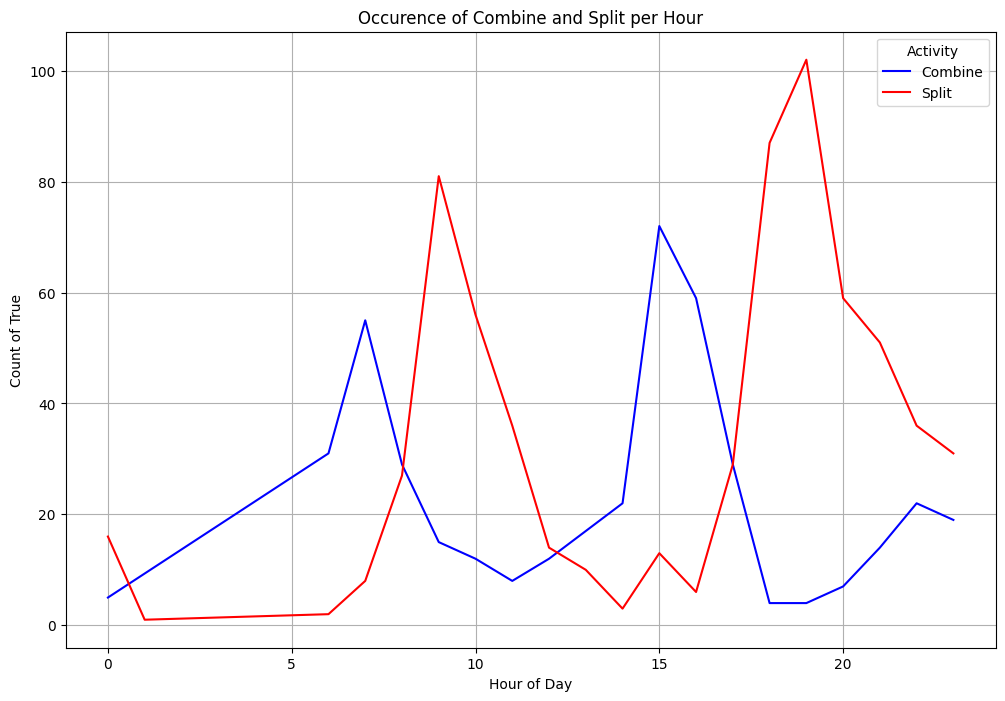

In [15]:
temp_df = turnover_df.copy()

# Create new hourly column
temp_df['Hour'] = temp_df['PLAN_DATETIME'].dt.hour

# Summarizing the counts of '1's for 'COMBINE' per hour
hourly_combine_counts = temp_df[temp_df['COMBINE'] == 1].groupby('Hour').size()

# Summarizing the counts of '1's for 'SPLIT' per hour
hourly_split_counts = temp_df[temp_df['SPLIT'] == 1].groupby('Hour').size()

# plotting
plt.figure(figsize=(12, 8))

sns.lineplot(x=hourly_combine_counts.index, y=hourly_combine_counts.values, 
             color='blue', label='Combine')
sns.lineplot(x=hourly_split_counts.index, y=hourly_split_counts.values, 
             color='red', label='Split')

plt.title('Occurence of Combine and Split per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count of True')
plt.legend(title='Activity')
plt.grid(True)
plt.show()


Most trunovers happen during the day,at the afternoon peak. The morning peak and night have less turnovers. Nightly turnovers are significantly longer.

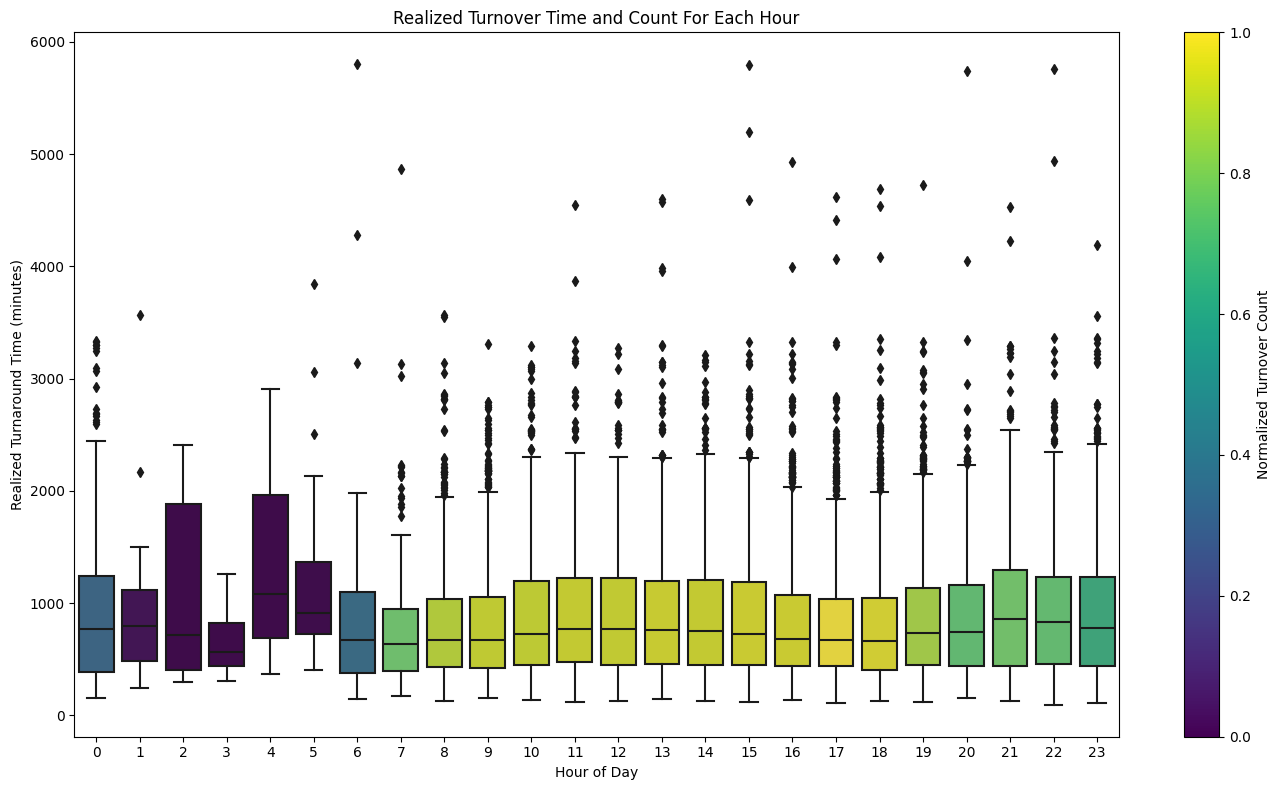

In [16]:
temp_df = turnover_df.copy()

#Create new hourly column
temp_df['Hour'] = temp_df['PLAN_DATETIME'].dt.hour

# Count turnarounds per hour
turnover_counts = temp_df.groupby('Hour').size()

# Normalizing the turnover counts to get a relative scale
norm_counts = (turnover_counts - turnover_counts.min()) / (turnover_counts.max() - turnover_counts.min())

color_map = plt.get_cmap('viridis')

# Create a color mappable object with normalization
norm = mcolors.Normalize(vmin=0, vmax=1)  # Normalize between 0 and 1
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  # Only needed for older Matplotlib versions without 'ScalarMappable.set_array'

# Map normalized counts to the color map
colors = {hour: color_map(norm(value)) for hour, value in norm_counts.items()}


# plotting
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Hour', y='REALIZED_TURNOVER_TIME', data=temp_df, palette=colors)

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Turnover Count')

plt.title('Realized Turnover Time and Count For Each Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Realized Turnaround Time (minutes)')
plt.tight_layout()
plt.show()


## 3. Turnover Times

The largest delays occur because of a signal delay

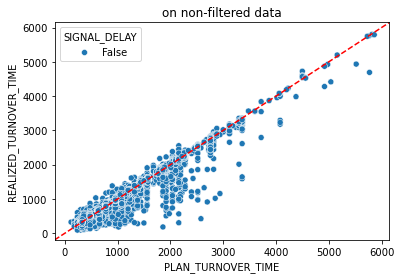

In [20]:
temp_df = turnover_df.copy()
temp_df['SIGNAL_DELAY'] = np.where((temp_df["PLAN_SIGNAL_SAFE_DELAY"] <= 0), False, True)

fig = sns.scatterplot(temp_df, x="PLAN_TURNOVER_TIME", y="REALIZED_TURNOVER_TIME", hue = "SIGNAL_DELAY")

# Get current axes, will use it to set limits and draw line
ax = plt.gca()

# Get limits for x and y axis
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Set the limits of x and y axis to be the same to maintain aspect ratio
lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
ax.set_xlim(lim)
ax.set_ylim(lim)

# Draw a diagonal line from (min, min) to (max, max)
plt.title("on non-filtered data")
plt.plot(lim, lim, 'r--')  

# Save the figure
plt.savefig('turnover_plot.png')  
plt.show() 

Text(0, 0.5, 'Delay (seconds)')

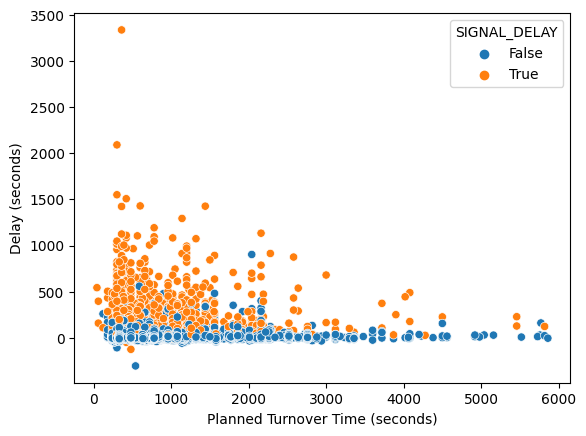

In [18]:
fig = sns.scatterplot(temp_df, x="PLAN_TURNOVER_TIME", y="DELAY", hue = "SIGNAL_DELAY")

fig.get_xaxis().set_label_text('Planned Turnover Time (seconds)')
fig.get_yaxis().set_label_text('Delay (seconds)')

About 80% of trains are on time:

<Axes: xlabel='ON_TIME', ylabel='count'>

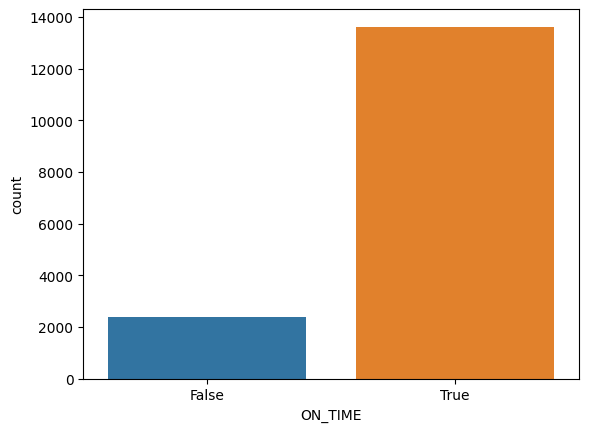

In [19]:
temp_df = turnover_df.copy()
temp_df["ON_TIME"] = np.where((temp_df["NEEDED_PLAN_TURNOVER_TIME"] >= temp_df["REALIZED_TURNOVER_TIME"]), True, False )

sns.countplot(temp_df, x = "ON_TIME")

## 3. Combining and Splitting

Combining and splitting of trains is rarely done.

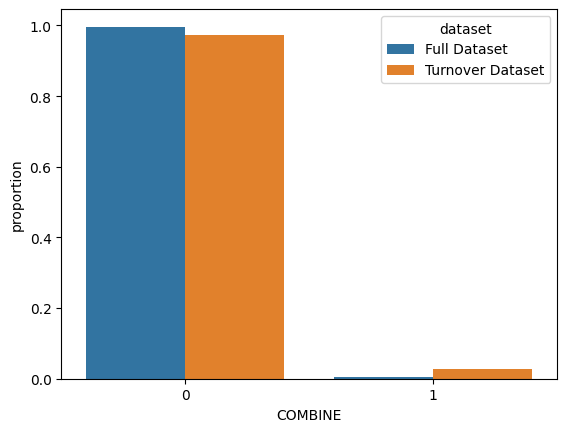

In [20]:
# Calculate proportions for the full dataset
full_counts = df_full['COMBINE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['COMBINE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['COMBINE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['COMBINE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(combined_data, x='COMBINE',y = 'proportion', hue = "dataset")
plt.show()

<Axes: xlabel='SPLIT', ylabel='proportion'>

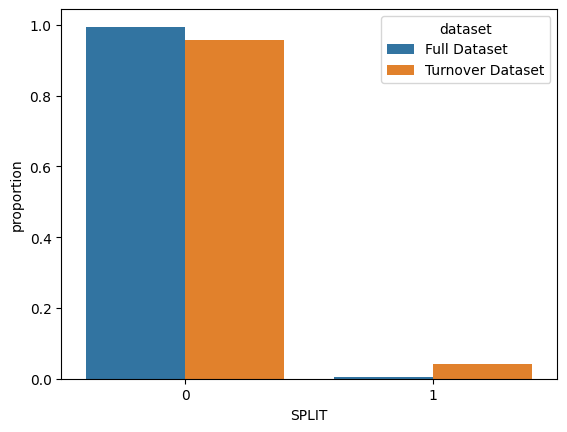

In [21]:
# Calculate proportions for the full dataset
full_counts = df_full['SPLIT'].value_counts(normalize=True).reset_index()
full_counts.columns = ['SPLIT', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['SPLIT'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['SPLIT', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])
sns.barplot(combined_data, x = "SPLIT", y = 'proportion', hue = 'dataset')

Combining and splitting have a significant influence on turnover time:

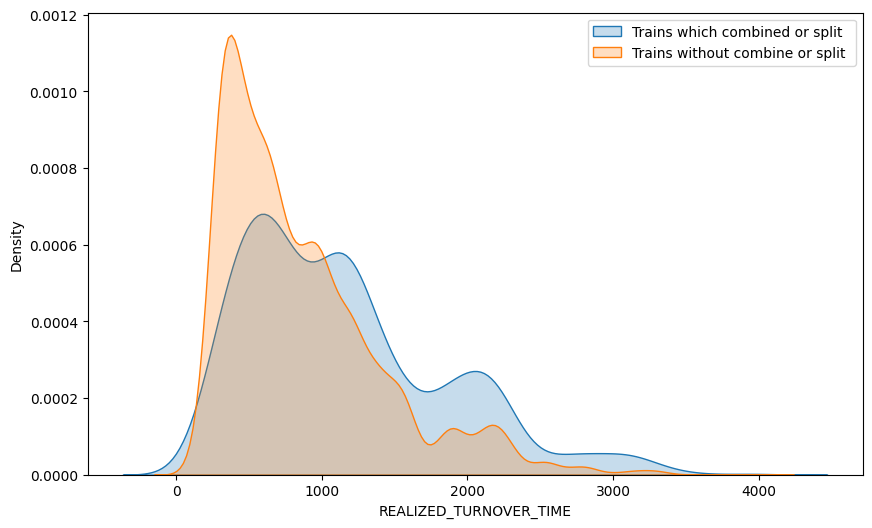

In [22]:
# Limit Turnover time
temp_df = turnover_df
temp_df = temp_df.loc[temp_df["REALIZED_TURNOVER_TIME"] < 4000]


# Create separate dataframes for combined/split trains
combine_and_split = temp_df[(temp_df["COMBINE"] == 1) | (temp_df["SPLIT"] == 1)]
no_combine_or_split = temp_df[(temp_df["COMBINE"] == 0) & (temp_df["SPLIT"] == 0)]
                                  
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combine_and_split['REALIZED_TURNOVER_TIME'], label='Trains which combined or split', fill=True)
sns.kdeplot(data=no_combine_or_split['REALIZED_TURNOVER_TIME'], label='Trains without combine or split ', fill=True)

plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.legend()
plt.show()

## 4.  Signal Safe Delay

In [23]:
print('Dataframe size before deleting signal delayed trains: ', len(non_filtered_df))
print('Dataframe size after deleting signal delayed trains: ', len(turnover_df))

reduction_percentage = ((len(non_filtered_df) - len(turnover_df)) / len(non_filtered_df)) * 100
print('Dataframe was reduced by {:.2f}% (excluding pre-filtering extreme values)'.format(reduction_percentage))

Dataframe size before deleting signal delayed trains:  18201
Dataframe size after deleting signal delayed trains:  16007
Dataframe was reduced by 12.05% (excluding pre-filtering extreme values)


<Axes: xlabel='PLAN_SIGNAL_SAFE_DELAY', ylabel='Count'>

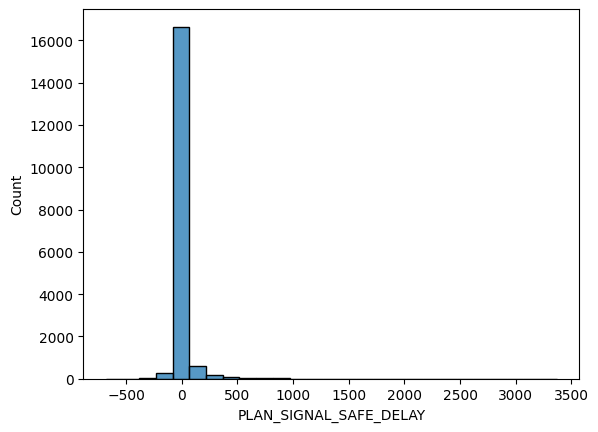

In [24]:
sns.histplot(non_filtered_df, x = "PLAN_SIGNAL_SAFE_DELAY", binwidth = 150)

<Axes: xlabel='PLAN_SIGNAL_SAFE_DELAY', ylabel='Count'>

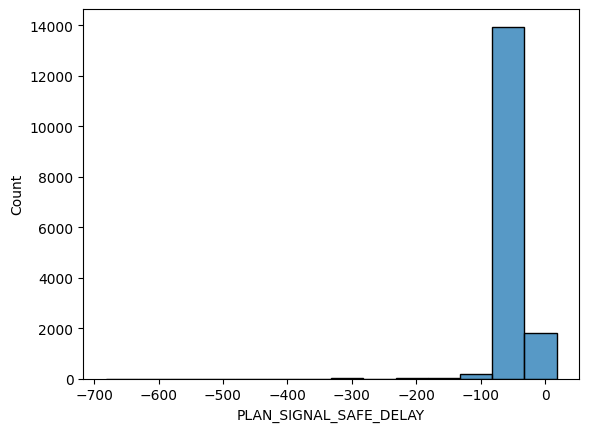

In [25]:
sns.histplot(turnover_df, x = "PLAN_SIGNAL_SAFE_DELAY", binwidth = 50)

## 5. Rolling Stock Type

Some rolling stock types seem to perform turnovers more than others:

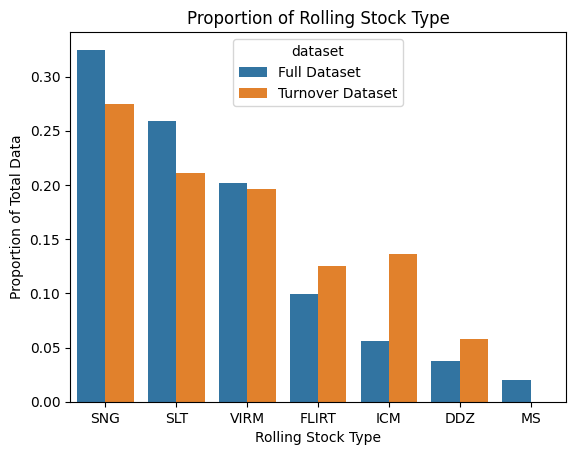

In [26]:
# Calculate proportions for the full dataset
full_counts = df_full['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['ROLLINGSTOCK_TYPE'].value_counts().index

sns.barplot(data=combined_data, x='ROLLINGSTOCK_TYPE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Rolling Stock Type')
plt.xlabel('Rolling Stock Type')
plt.ylabel('Proportion of Total Data')

plt.show()

<Axes: xlabel='PLAN_TURNOVER_TIME', ylabel='ROLLINGSTOCK_TYPE'>

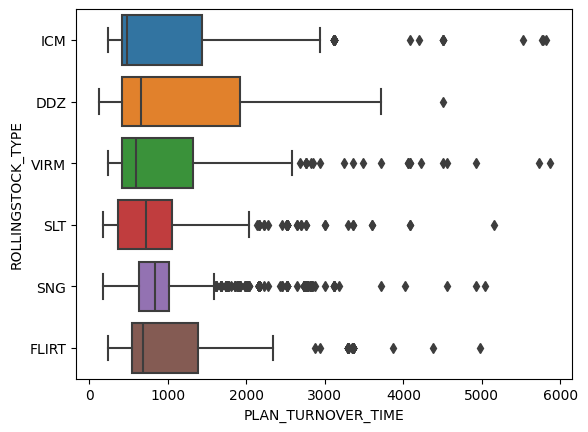

In [27]:
sns.boxplot(turnover_df, x = "PLAN_TURNOVER_TIME",y = "ROLLINGSTOCK_TYPE")

Some rollingstock types are influenced more by combining and splitting than others. In all cases, combining/splitting increases turnover time.

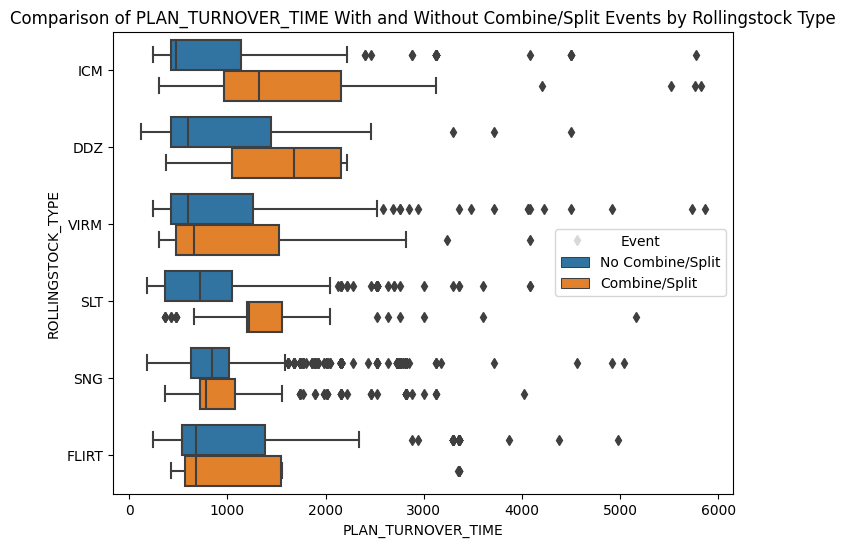

In [28]:
temp_df = turnover_df
temp_df['Event'] = np.where((temp_df['COMBINE'] == 1) | (temp_df['SPLIT'] == 1), 'Combine/Split', 'No Combine/Split')


plt.figure(figsize=(8, 6))
sns.boxplot(data=temp_df, x='PLAN_TURNOVER_TIME', y='ROLLINGSTOCK_TYPE', hue='Event')
plt.title('Comparison of PLAN_TURNOVER_TIME With and Without Combine/Split Events by Rollingstock Type')
plt.show()

## 6. Activity Types

<Axes: xlabel='ACTIVITYTYPE', ylabel='count'>

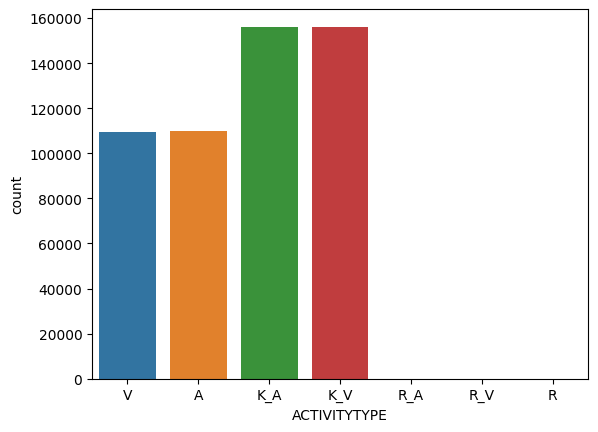

In [29]:
sns.countplot(df_full, x = "ACTIVITYTYPE")

<Axes: xlabel='TRAINSERIE_DIRECTION', ylabel='count'>

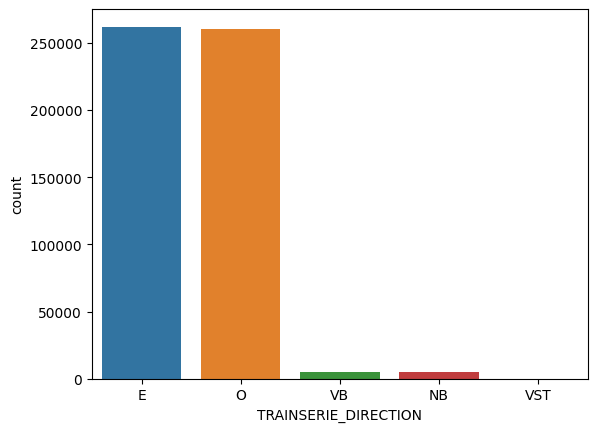

In [30]:
sns.countplot(df_full, x = "TRAINSERIE_DIRECTION")

## 7. Stations

Turnovers do not occur at all stations. Some of the busiest stations are never used for turnovers.

The turnover data has 81 unique stations
The regular data has 292 unique stations


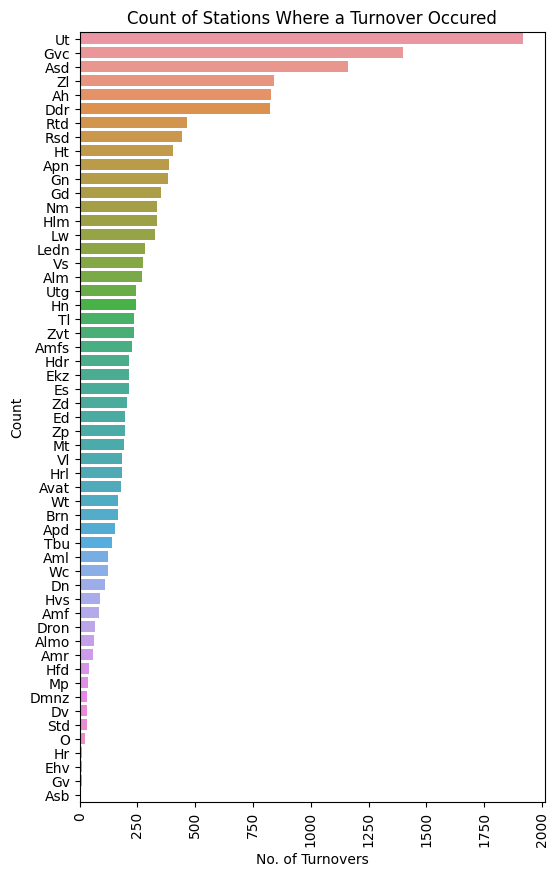

In [31]:
order = turnover_df['STATION'].value_counts().nlargest(55).index

# Inrease the figure size
plt.figure(figsize=(6, 10))  

sns.countplot(turnover_df, y = "STATION", order=order)

plt.title('Count of Stations Where a Turnover Occured')
plt.xlabel('No. of Turnovers')
plt.ylabel('Count')

plt.xticks(rotation=90)  

print('The turnover data has {} unique stations'.format(len(turnover_df['STATION'].unique())))
print('The regular data has {} unique stations'.format(len(df_full['STATION'].unique())))

plt.show()

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000'),
  Text(12000.0, 0, '12000'),
  Text(14000.0, 0, '14000'),
  Text(16000.0, 0, '16000')])

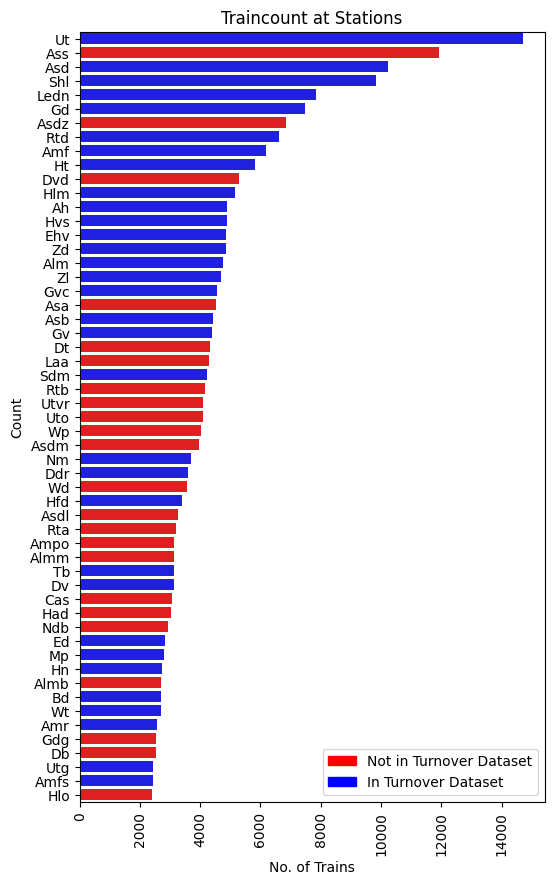

In [32]:
stations_in_turnover = set(turnover_df['STATION'])
df['IN_TURNOVER'] = df['STATION'].isin(stations_in_turnover).astype(int)

# Define color map
color_map = {0: 'red', 1: 'blue'}

order = df['STATION'].value_counts().nlargest(55).index

plt.figure(figsize=(6, 10))  

# Calculate counts
station_counts = df['STATION'].value_counts().loc[order]
colors = df.drop_duplicates(subset=['STATION']).set_index('STATION')['IN_TURNOVER'].map({0: 'red', 1: 'blue'}).reindex(order)

sns.barplot(y=station_counts.index, x=station_counts.values, palette=colors)

# Create legend patches
legend_patches = [mpatches.Patch(color=color_map[key], label=f'{"In Turnover Dataset" if key else "Not in Turnover Dataset"}') for key in color_map]

plt.legend(handles=legend_patches)
plt.title('Traincount at Stations')
plt.xlabel('No. of Trains')
plt.ylabel('Count')
plt.xticks(rotation=90)  


## 8. Rolling Stock Length

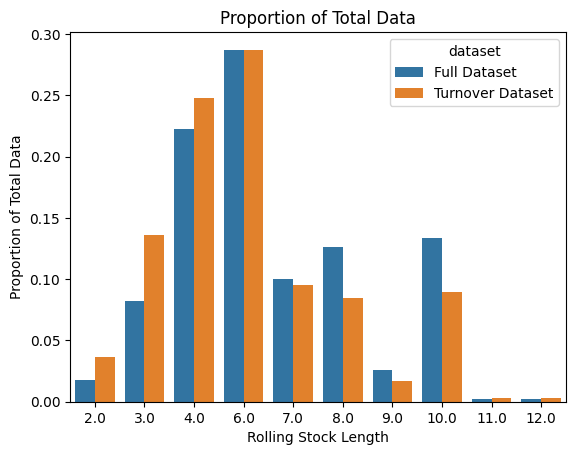

In [33]:
# Calculate proportions for the full dataset
full_counts = df_full['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
full_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(data=combined_data, x='NUMBER_CARRIAGES', y='proportion', hue='dataset')

plt.title('Proportion of Total Data')
plt.xlabel('Rolling Stock Length')
plt.ylabel('Proportion of Total Data')

plt.show()

On average, the turnover time seems to decrease with an increase in cariages.

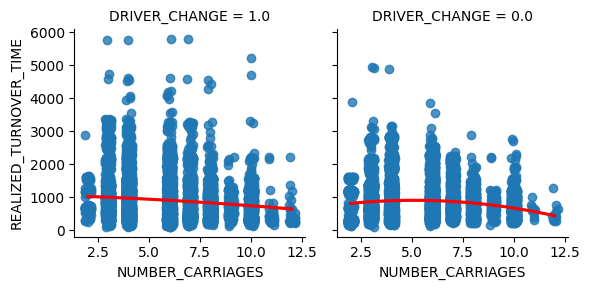

In [34]:
g = sns.FacetGrid(turnover_df, col="DRIVER_CHANGE")  
g.map(sns.regplot, "NUMBER_CARRIAGES", "REALIZED_TURNOVER_TIME", order=2, x_jitter=.15, line_kws={'color': 'red'})
plt.show()

## 9. Driver Change

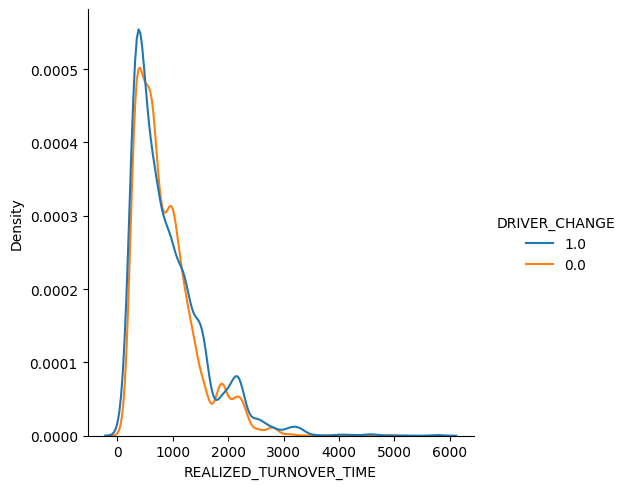

In [35]:
sns.displot(turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

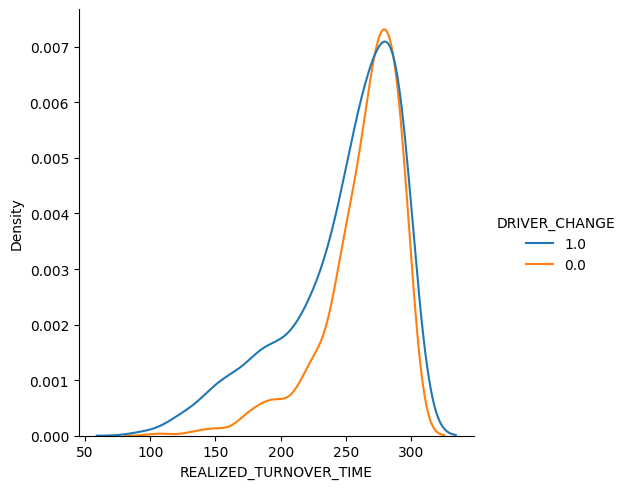

In [36]:
short_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] < 300]
sns.displot(short_turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

A driver change only has a positive impact when the planned turnover time is short, otherwise it has a negative impact on turnover time:

In [37]:
print('Short turnovers (5 minutes or less):', )
print(short_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())


long_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] > 900]
print()

print('Long turnovers (15 minutes or more):', )
print(long_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())



Short turnovers (5 minutes or less):
DRIVER_CHANGE
0.0    262.742481
1.0    248.662618
Name: REALIZED_TURNOVER_TIME, dtype: float64

Long turnovers (15 minutes or more):
DRIVER_CHANGE
0.0    1393.512812
1.0    1518.015161
Name: REALIZED_TURNOVER_TIME, dtype: float64


Driver changes are more likely to occur when a turnover happens as well:

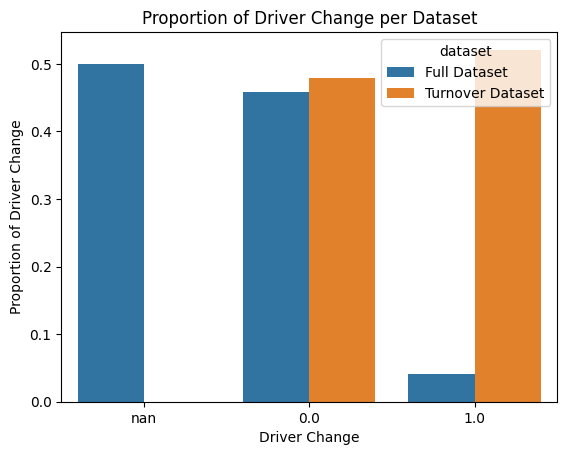

In [38]:
# Calculate proportions for the full dataset
full_counts = df_full['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['DRIVER_CHANGE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['DRIVER_CHANGE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['DRIVER_CHANGE'].value_counts().index

sns.barplot(data=combined_data, x='DRIVER_CHANGE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Driver Change per Dataset')
plt.xlabel('Driver Change')
plt.ylabel('Proportion of Driver Change')

plt.show()

## 10. Correlation Analysis

In [44]:
df_numerical = turnover_df[["DRIVER_CHANGE","NUMBER_CARRIAGES", "PLAN_TURNOVER_TIME", "REALIZED_TURNOVER_TIME", "DELAY"]]

corr = df_numerical.corr()
corr.style.background_gradient(cmap='coolwarm')

,DRIVER_CHANGE,NUMBER_CARRIAGES,PLAN_TURNOVER_TIME,REALIZED_TURNOVER_TIME,DELAY
DRIVER_CHANGE,1.000000,0.071895,0.038276,0.043219,0.031848
NUMBER_CARRIAGES,0.071895,1.000000,-0.088389,-0.097429,0.153007
PLAN_TURNOVER_TIME,0.038276,-0.088389,1.000000,0.979633,-0.038922
REALIZED_TURNOVER_TIME,0.043219,-0.097429,0.979633,1.000000,-0.022615
DELAY,0.031848,0.153007,-0.038922,-0.022615,1.000000
